# Data preprocessing and generation

This notebook shows how to use the pose_2D and pose_3D library to extract our model's input from a pifpaf output and how to generate 3D poses for our data set.

In [1]:
import pose_2D as pose2d
import pose_3D as pose3d
from importlib import reload
import matplotlib.pyplot as plt
import math
import numpy as np
import pickle as pkl
import random as rand
from functools import reduce

import plotly.graph_objects as go

import visual as vs

In [107]:
pose2d = reload(pose2d)
pose3d = reload(pose3d)
vs = reload(vs)

## 1- Preprocess PIFPAF

We load all the pifpaf outputs and extract the body and face proportions

#### a- Load PIFPAF

In [108]:
pifpaf = pose2d.load_pifpaf('../../jeanmarc_data/data/proportions/')

we loaded 12 pedestrians


Example of pifpaf structure

In [109]:
pifpaf[6]

{'ppbox': [195.62414360046387,
  153.22647094726562,
  297.7799679040909,
  471.74649810791016],
 'confidence': [1.0,
  1.0,
  0.9,
  1.1,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.8,
  0.9,
  0.9,
  0.8,
  0.8,
  0.5,
  0.8,
  0.6],
 'image_id': '000009',
 'og_keypoints': array([[248.3, 256. , 241.2, 265. , 230.8, 284.1, 212.7, 297.5, 202.4,
         297.8, 195.6, 268.6, 226. , 266.8, 225.4, 270.3, 218.4],
        [160.1, 154. , 153.2, 161. , 159.3, 211.8, 213.2, 270.6, 269. ,
         325.6, 324.7, 327.4, 319.2, 397.4, 391.9, 471.7, 469.4]]),
 'conv_keypoints': array([ 0.00313972, -0.51240188, -0.10863422, -0.34568289, -0.14097331,
        -0.17048666, -0.16232339,  0.0043956 ,  0.1155416 , -0.35007849,
         0.15761381, -0.16546311,  0.15855573,  0.00722135, -0.06687598,
        -0.01287284, -0.06875981,  0.21538462, -0.09073783,  0.45871272,
         0.06687598,  0.01287284,  0.06122449,  0.23265306,  0.0722135 ,
         0.46593407, -0.01915228, -0.53406593,  0.02731554, -0.531554

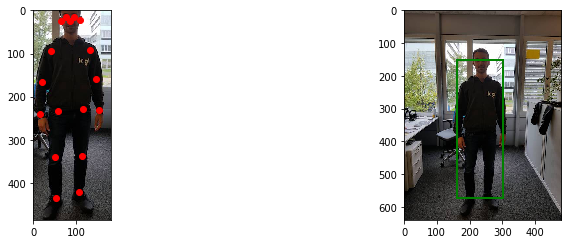

In [116]:
vs.show_pp_on_image(pifpaf[4],'../../jeanmarc_data/data/proportions_images/','.jpg')

#### b- Extract all proportions

In [111]:
all_props, all_face_pos = [], []

for i in range(int(len(pifpaf)/2)):
    
    front_view = pifpaf[2*i]['conv_keypoints']
    side_view = pifpaf[2*i+1]['conv_keypoints']
    
    body_props, face_pos = pose2d.get_proportions(front_view, side_view)
    
    all_props.append(body_props)
    all_face_pos.append(face_pos)

In [112]:
mean_prop = {}
mean_face_pos = {}
std_prop = {}
std_face_pos = {}

for key in all_props[0].keys():
    mean_prop[key] = np.mean([prop[key] for prop in all_props])
    std_prop[key] = np.std([prop[key] for prop in all_props])

for key in all_face_pos[0].keys():
    mean_face_pos[key] = list(np.mean(np.array([face[key] for face in all_face_pos]), axis = 0))
    std_face_pos[key] = list(np.std(np.array([face[key] for face in all_face_pos]), axis = 0))


In [113]:
'The mean is', mean_prop, mean_face_pos,'The standard deviation is', std_prop, std_face_pos

('The mean is',
 {'neck': 0.08312894160847069,
  'shoulder': 0.143356989098749,
  'biceps': 0.19194335856708392,
  'forearm': 0.17344071916326764,
  'quad': 0.2366474659684447,
  'tibias': 0.21729385918394697,
  'hip': 0.1455833518533279,
  'back': 0.21891155259576892},
 {'nose': [0.0, 0.0, 0.07694974654347399],
  'eye': [0.0189800254458759, 0.02059930889146827, 0.06613372119368856],
  'ear': [0.0504435061876175, 1.850371707708594e-17, 0.0]},
 'The standard deviation is',
 {'neck': 0.0023866418292290913,
  'shoulder': 0.005910914396303623,
  'biceps': 0.01280255701076115,
  'forearm': 0.005259701129474702,
  'quad': 0.011448147360241289,
  'tibias': 0.013703702321166867,
  'hip': 0.0084450423873918,
  'back': 0.007197511926349074},
 {'nose': [0.0, 0.0, 0.01875619766411373],
  'eye': [0.0035289281617600114, 0.003936514621175161, 0.019812386659796014],
  'ear': [0.004352596196910019, 4.137556922078789e-17, 0.0]})

In [114]:
all_base_poses = []
for prop, face_pos in zip(all_props,all_face_pos):
    all_base_poses.append(pose2d.generate_3D_model(prop, face_pos).reshape((21,3)).transpose())

In [115]:
go.Figure(vs.plot([x.transpose().flatten() for x in all_base_poses]))

## 2- Generate DATASET

In [9]:
angle_limits = {'head': [[-math.pi/2, math.pi/4],
                         [-math.pi/2, math.pi/2],
                         [-math.pi/4, math.pi/4]],
                'back': [[-math.pi/3,         0],
                         [-math.pi/2, math.pi/2],
                         [-math.pi/6, math.pi/6]],
                'x':    [[-math.pi/5, math.pi/4]],
                'y':    [[-math.pi/3, math.pi/3]],
                'z':    [[-math.pi/6, math.pi/6]]}

In [10]:
angle_dic = {'head':[-0.2,
                     0.3,
                     -0.2],
             'back':[-0.2,
                     0.1,
                     -0.4],
             'x':   [0],
             'y':   [0.3],
             'z':   [0]}

In [16]:
def range2angles(member_name, angle_index, sample_size):
    lower_value = angle_limits[member_name][angle_index][0]
    higher_value = angle_limits[member_name][angle_index][1]
    step = (higher_value-lower_value)/(sample_size-1)
    return [lower_value+x*step for x in range(sample_size)]

In [17]:
%%time
size = 5
l0 = range2angles('head', 0, size)
l1 = range2angles('head', 1, size)
l2 = range2angles('head', 2, size)
l3 = range2angles('back', 0, size)
l4 = range2angles('back', 1, size)
l5 = range2angles('back', 2, size)
l6 = range2angles('x', 0, size)
l7 = range2angles('y', 0, size)
l8 = range2angles('z', 0, size)

data_set_3d = []
data_set_2d = []
data_set_angles = []
data_set_props = []

for a0 in l0:
    for a1 in l1:
        for a2 in l2:
            for a3 in l3:
                for a4 in l4:
                    for a5 in l5:
                        for a6 in l6:
                            for a7 in l7:
                                for a8 in l8:
                                    angle_dic = {'head':[a0,
                                                         a1,
                                                         a2],
                                                 'back':[a3,
                                                         a4,
                                                         a5],
                                                 'x':   [a6],
                                                 'y':   [a7],
                                                 'z':   [a8]}
                                    index = rand.sample(range(len(all_base_poses)), 1)[0]
                                    base_3d_pose = all_base_poses[index]
                                    pose = pose3d.full_pose_rotation(base_3d_pose, angle_dic)
                                    
                                    data_set_3d.append(pose.transpose().flatten())
                                    data_set_2d.append(pose[:2].transpose().flatten())
                                    data_set_angles.append([a0,a1,a2,a3,a4,a5,a6,a7,a8])
                                    data_set_props.append([x[1] for x in all_props[index].items()]+\
                                                          reduce(lambda x, y: x+y, [x[1] for x in\
                                                          all_face_pos[index].items()]))
                                    
pkl.dump((np.array(data_set_3d), np.array(data_set_2d), np.array(data_set_angles), np.array(data_set_props)),\
         open( "DATASET3.pkl", "wb" ) )                                  

CPU times: user 45min 53s, sys: 8.49 s, total: 46min 2s
Wall time: 45min 56s


In [11]:
data_set_3d, data_set_2d, data_set_angles, data_set_props = pkl.load(open( "DATASET3.pkl", "rb" ))

In [12]:
len(data_set_3d)

1953125

## 3- Try the KNN approach

#### a- Compute the 2d norm between a test sample pp1 and all generated poses

In [15]:
norms = []
pp1 = pifpaf[6]['conv_keypoints']
for data in data_set_2d:
    norms.append(np.linalg.norm(pp1-data))

#### b- find the closest pose to pp1

In [16]:
ind = 10
dict(zip(np.argsort(norms)[:ind],np.sort(norms)[:ind]))

{1373462: 0.1627847641575045,
 982812: 0.17070989695206695,
 1698462: 0.17081224127946243,
 1832837: 0.1728017726287923,
 1045337: 0.17473255161903942,
 1357218: 0.17483794409900436,
 1301587: 0.1753965150533873,
 1366468: 0.17558256721006874,
 1054712: 0.17559166664600512,
 1072718: 0.17585810784005362}

## 4- Generate the data for the Torso

In [19]:
torso_co = [(0,20),(0,13),(0,14),(13,15),(14,16),(1,4),(10,4),(7,1),(18,7),(18,10)]

In [20]:
joints2keep = ['left hip', 'right hip', 'nose', 'right shoulder','left shoulder', 'right eye','left eye',
               'right ear','left ear','center shoulder','center hip','center back','head']


In [50]:
%%time
data_set_torso_2d = []
for pose in data_set_3d:
    
    new_pose = pose3d.filter_joints(pose.reshape((21,3)).transpose(),joints2keep, 0)
    new_pose = pose3d.normalize(new_pose)
    new_pose = pose3d.filter_joints(new_pose,joints2keep, -10)
    data_set_torso_2d.append(new_pose[:2].transpose().flatten())
    

CPU times: user 1min 1s, sys: 3.09 ms, total: 1min 1s
Wall time: 1min 1s


In [51]:
data_set_torso_2d[0]

array([ -1.97503386,  -0.50588651,  -1.4365615 ,  -0.81549407,
       -10.        , -10.        , -10.        , -10.        ,
        -1.27970834,   0.18450593, -10.        , -10.        ,
       -10.        , -10.        ,  -0.11318529,   0.06534756,
       -10.        , -10.        , -10.        , -10.        ,
         0.11318529,  -0.06534756, -10.        , -10.        ,
       -10.        , -10.        ,  -2.06324483,  -0.46816445,
        -2.00913439,  -0.44361449,  -1.997065  ,  -0.26562331,
        -1.86847996,  -0.20728415,  -1.63821279,  -0.30183497,
         0.        ,   0.        ,  -0.66215614,  -0.3494362 ,
        -1.93277248,  -0.23645373])

### Try KNN on the torso

In [88]:
norms = []
pp1 = pifpaf[4]['conv_keypoints']
pp1 = pose2d.filter_joints(pp1.reshape((21,2)).transpose(), joints2keep, 0)
pp1 = pose2d.normalize(pp1)
pp1 = pose2d.filter_joints(pp1, joints2keep, -10).transpose().flatten()
for data in data_set_torso_2d:
    norms.append(np.linalg.norm(pp1-data))

In [89]:
ind = 10
dict(zip(np.argsort(norms)[:ind],np.sort(norms)[:ind]))

{1364112: 0.092596578019878,
 1432956: 0.09753690389484128,
 1754712: 0.09887480603711422,
 1764012: 0.0994311191525267,
 1295416: 0.1013420158145007,
 1286612: 0.10242262397753839,
 1441612: 0.10368423254540178,
 1370337: 0.10464528073576923,
 1751587: 0.10646529677506499,
 1764037: 0.10873469889102033}

In [92]:
go.Figure(vs.plot([data_set_torso_2d[1432956],pp1],torso_co))#, connections=torso_co))#.reshape((21,3))[:,:2].flatten()]))

In [93]:
go.Figure(vs.plot([ data_set_3d[1432956]]))#, connections=torso_co))#.reshape((21,3))[:,:2].flatten()]))

## 5- Generate TRAINING DATA

In [84]:
print(np.array(data_set_torso_2d).shape)
print(data_set_props.shape)
print(data_set_angles.shape)

(1953125, 42)
(1953125, 17)
(1953125, 9)


In [85]:
inputs = np.concatenate((np.array(data_set_torso_2d), data_set_props), axis=1)

In [87]:
pkl.dump((inputs, data_set_angles), open( "TRAIN.pkl", "wb" ) )

In [ ]:
intrinsic matrix
648.778092502481	0	0
0.379905834100745	647.017429791046	0
371.772368487809	233.825866379108	1

720x480

In [ ]:
1437.08904305765	0	0
-1.42692919774288	1440.08246297008	0
982.090686070036	491.675343766253	1

## 6- Full body random range data

#### a- generate the distribution of proportions

In [9]:
angle_limits = {'head': [[-math.pi/2, math.pi/4],
                         [-math.pi/2, math.pi/2],
                         [-math.pi/4, math.pi/4]],
                'back': [[-math.pi/3,         0],
                         [-math.pi/2, math.pi/2],
                         [-math.pi/6, math.pi/6]],
                'x':    [[-math.pi/5, math.pi/4]],
                'y':    [[-math.pi/3, math.pi/3]],
                'z':    [[-math.pi/6, math.pi/6]]}

In [ ]:
angle_dic = {'head':[a0,
                     a1,
                     a2],
             'back':[a3,
                     a4,
                     a5],
             'x':   [a6],
             'y':   [a7],
             'z':   [a8]}

In [11]:
def project_to_pixels(xyz, kk):
    """Project a single point in space into the image"""
    xx, yy, zz = np.dot(kk, xyz)
    uu = int(xx / zz)
    vv = int(yy / zz)

    return uu, vv